# This notebook reproduces the main results in Figure 2 and its associated Supplementary Figures.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "iframe"
import scanpy as sc
import celltypist

In [2]:
adata = sc.read('Validation_five_immune_datasets.h5ad')
adata

AnnData object with n_obs × n_vars = 417866 × 53147
    obs: 'Harmonised_broad_type', 'Harmonised_detailed_type', 'Label_from_original_study', 'Tissue', 'Dataset', 'Protocol', 'Iteration'
    var: 'highly_variable'

Normalised expression is in `.X`.

In [3]:
adata.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [ 9999.999]], dtype=float32)

Perform a classical workflow: HVGs -> scaling -> PCA -> neighborhood graph -> UMAP

In [4]:
adata = adata[:, adata.var.highly_variable].copy()
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Examine batches.

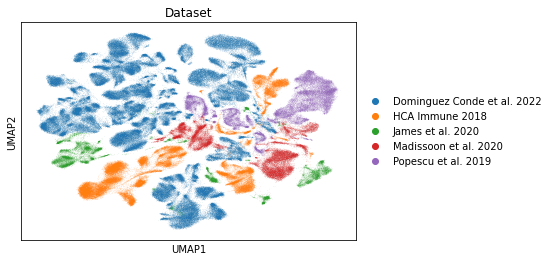

In [5]:
sc.pl.umap(adata, color = 'Dataset')

Examine original author annotations.

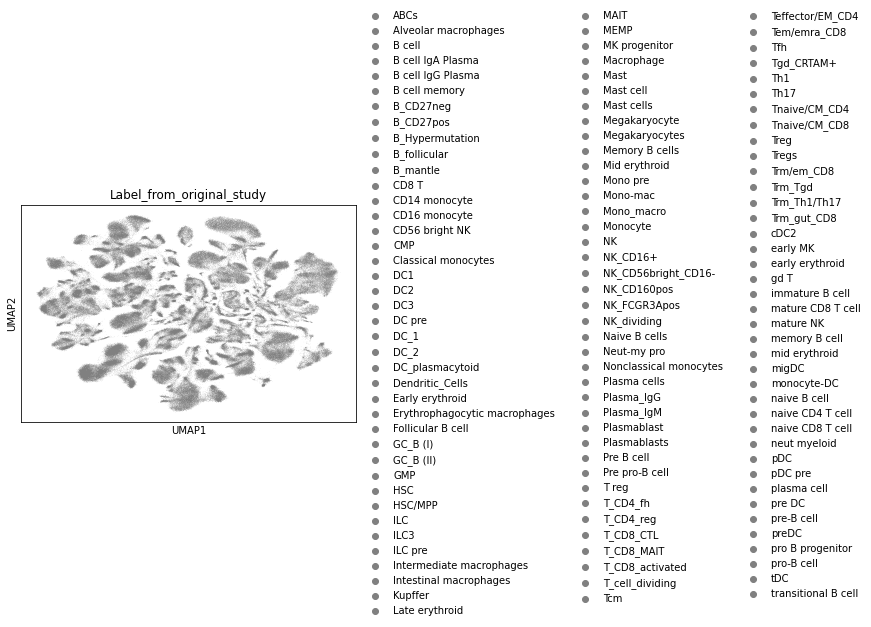

In [6]:
sc.pl.umap(adata, color = 'Label_from_original_study')

Examine the ground-truth annotations.

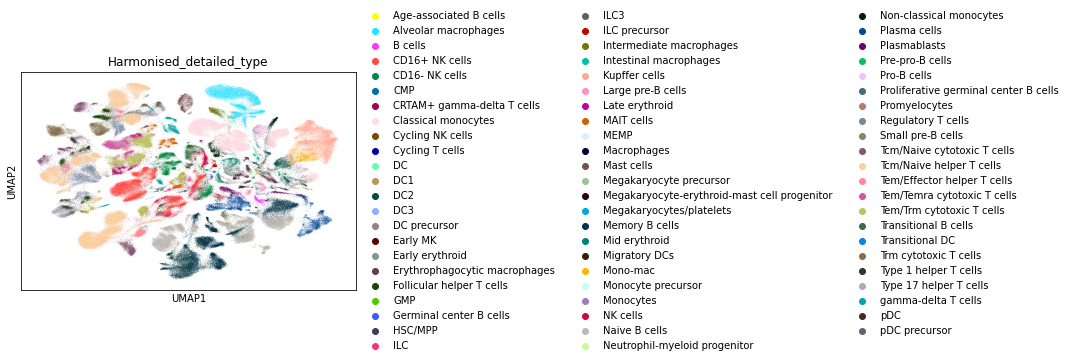

In [7]:
sc.pl.umap(adata, color = 'Harmonised_detailed_type')

Perform cell type harmonisation using CellTypist.

In [8]:
# Note - PCT is turned on.
alignment = celltypist.harmonize(adata, 'Dataset', 'Label_from_original_study', use_pct = True, dataset_order = ['Madissoon et al. 2020', 'Dominguez Conde et al. 2022', 'James et al. 2020', 'HCA Immune 2018', 'Popescu et al. 2019'])

👀 Detected PCA coordinates in the object, will use these to calculate distances
🏋️ Training the predictive clustering trees for:
      Dominguez Conde et al. 2022
      HCA Immune 2018
      James et al. 2020
      Madissoon et al. 2020
      Popescu et al. 2019
🖋️ Predicting distances using the PCT in each dataset
🖇 Harmonizing cell types of Madissoon et al. 2020 and Dominguez Conde et al. 2022
🖇 Harmonizing cell types of James et al. 2020
🖇 Harmonizing cell types of HCA Immune 2018
🖇 Harmonizing cell types of Popescu et al. 2019
🖋️ Reannotating cells
✅ Harmonization done!


Save the harmonisation result.

In [9]:
alignment.write('Immune_alignment.pkl')

Load the harmonisation result and visualise it.

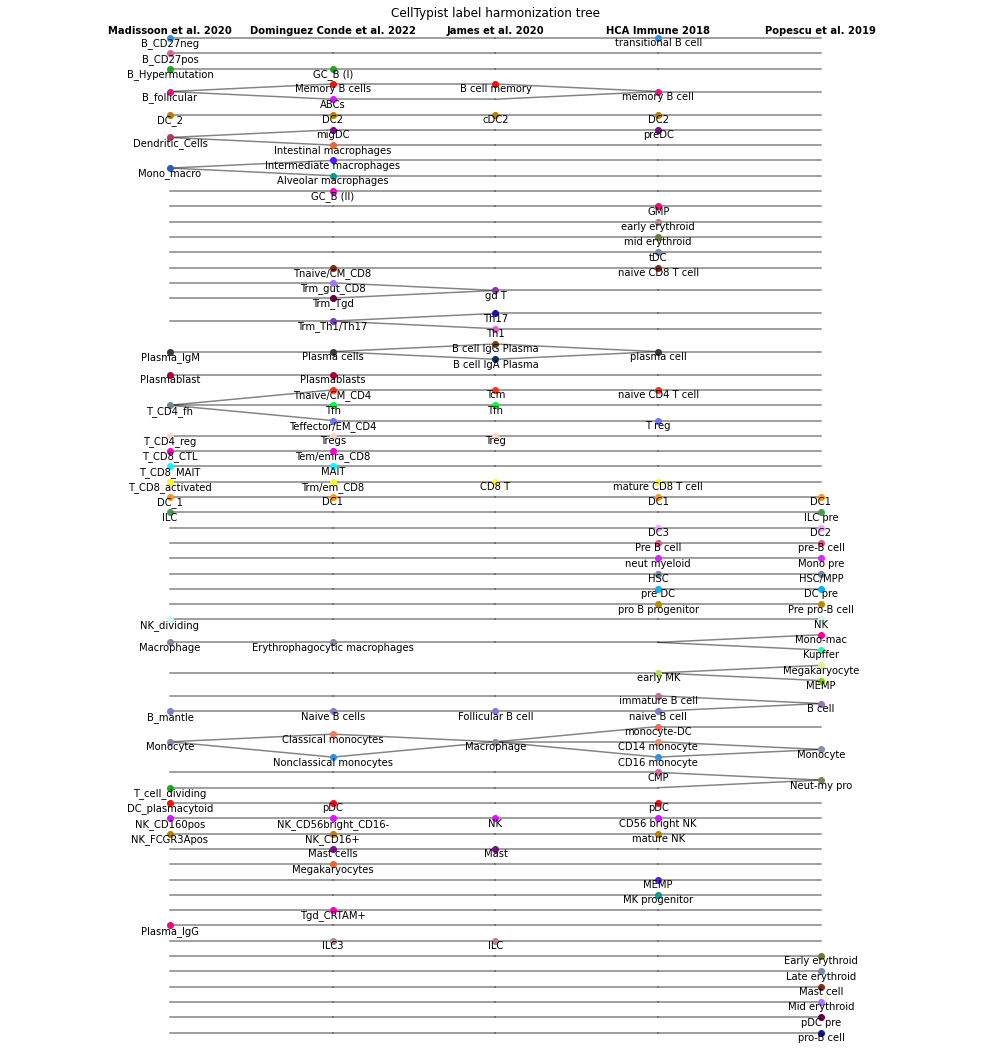

In [10]:
alignment = celltypist.DistanceAlignment.load('Immune_alignment.pkl')
celltypist.treeplot(alignment)

Visualise the cell type hierarchy.

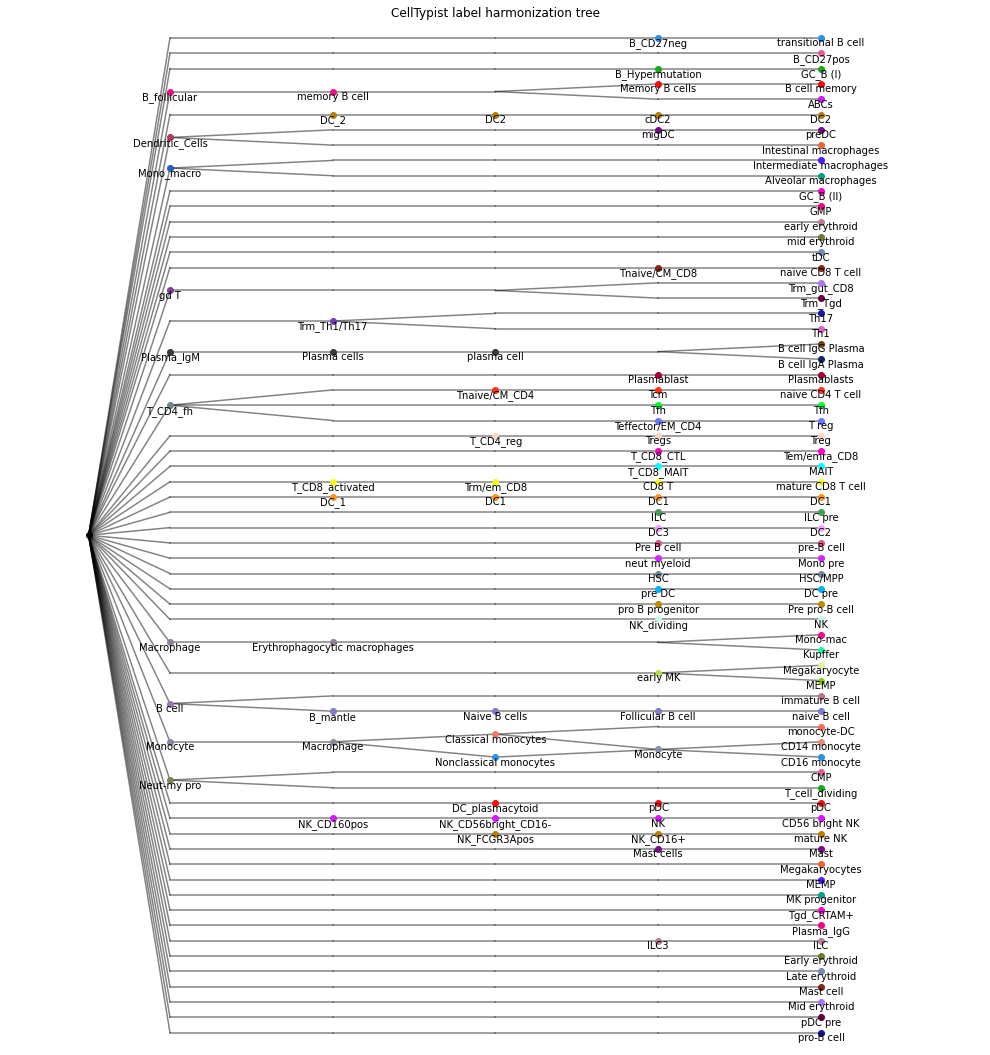

In [11]:
celltypist.treeplot(alignment, order_dataset = True)

Perform meta-analysis and visualise it with heat map.

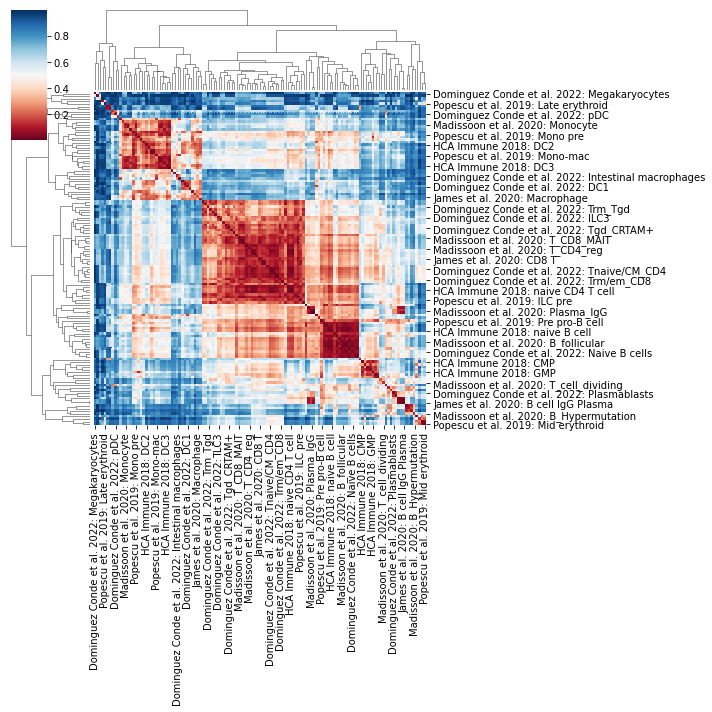

In [12]:
sns.clustermap(alignment.base_distance.to_meta(), cmap = 'RdBu')

Check the harmonisation table.

In [13]:
alignment.relation.head(10)

,Madissoon et al. 2020,relation,Dominguez Conde et al. 2022,relation,James et al. 2020,relation,HCA Immune 2018,relation,Popescu et al. 2019
0,B_CD27neg,=,NONE,=,NONE,=,transitional B cell,=,NONE
1,B_CD27pos,=,NONE,=,UNRESOLVED,=,NONE,=,NONE
2,B_Hypermutation,=,GC_B (I),=,NONE,=,UNRESOLVED,=,NONE
3,B_follicular,∋,ABCs,=,UNRESOLVED,∈,memory B cell,=,NONE
4,B_follicular,∋,Memory B cells,=,B cell memory,∈,memory B cell,=,NONE
5,DC_2,=,DC2,=,cDC2,=,DC2,=,NONE
6,Dendritic_Cells,∋,migDC,=,NONE,=,preDC,=,NONE
7,Mono_macro,∋,Alveolar macrophages,=,NONE,=,NONE,=,NONE
8,NONE,=,GC_B (II),=,NONE,=,NONE,=,NONE
9,NONE,=,NONE,=,NONE,=,GMP,=,NONE


Focus on the CD8 T cells.

In [14]:
alignment.relation[np.isin(alignment.groups,['Group13', 'Group20', 'Group22'])]

,Madissoon et al. 2020,relation,Dominguez Conde et al. 2022,relation,James et al. 2020,relation,HCA Immune 2018,relation,Popescu et al. 2019
13,NONE,=,Tnaive/CM_CD8,=,NONE,=,naive CD8 T cell,=,NONE
25,T_CD8_CTL,=,Tem/emra_CD8,=,NONE,=,UNRESOLVED,=,NONE
27,T_CD8_activated,=,Trm/em_CD8,=,CD8 T,=,mature CD8 T cell,=,NONE


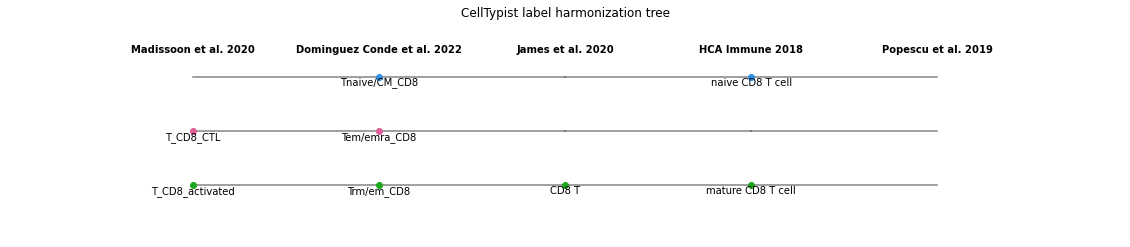

In [15]:
celltypist.treeplot(alignment.relation[np.isin(alignment.groups, ['Group13', 'Group20', 'Group22'])], figsize = [20, 4])

In [16]:
celltypist.sankeyplot(alignment.relation[np.isin(alignment.groups, ['Group13', 'Group20', 'Group22'])])

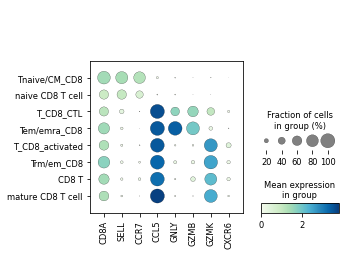

In [17]:
adata = sc.read('Validation_five_immune_datasets.h5ad')
labels_want = ['Tnaive/CM_CD8', 'naive CD8 T cell', 'T_CD8_CTL', 'Tem/emra_CD8', 'T_CD8_activated', 'Trm/em_CD8', 'CD8 T', 'mature CD8 T cell']
adata = adata[adata.obs.Label_from_original_study.isin(labels_want)].copy()
adata.obs['Label_from_original_study'].cat.reorder_categories(labels_want, inplace=True)
sc.pl.dotplot(adata, ['CD8A', 'SELL', 'CCR7', 'CCL5', 'GNLY', 'GZMB', 'GZMK', 'CXCR6'], groupby = 'Label_from_original_study', cmap = 'GnBu')

Next, focus on `Group4`. 

In [18]:
alignment.relation[alignment.groups=='Group4']

,Madissoon et al. 2020,relation,Dominguez Conde et al. 2022,relation,James et al. 2020,relation,HCA Immune 2018,relation,Popescu et al. 2019
3,B_follicular,∋,ABCs,=,UNRESOLVED,∈,memory B cell,=,NONE
4,B_follicular,∋,Memory B cells,=,B cell memory,∈,memory B cell,=,NONE


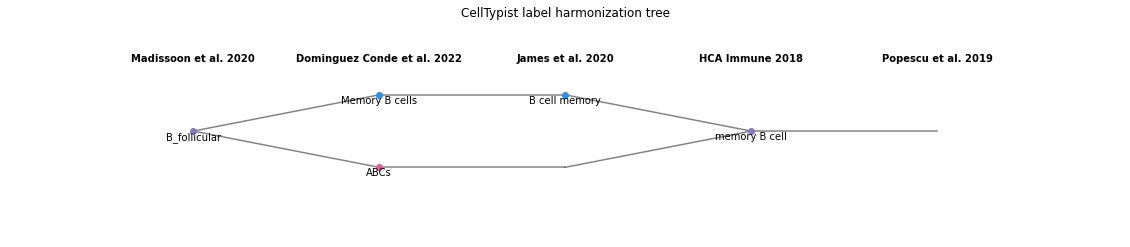

In [19]:
celltypist.treeplot(alignment.relation[alignment.groups=='Group4'], figsize = [20, 4])

In [20]:
celltypist.sankeyplot(alignment.relation[alignment.groups=='Group4'])

Locate ABCs (using `B_follicular` in `Madissoon et al. 2020` as an example).

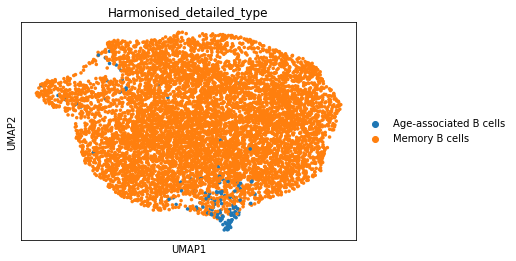

In [21]:
adata = sc.read('Validation_five_immune_datasets.h5ad')
model = celltypist.Model.load()
markers = np.union1d(model.extract_top_markers('Memory B cells', 50), model.extract_top_markers('Age-associated B cells', 50))
adata = adata[adata.obs.Label_from_original_study=='B_follicular'].copy()
adata.raw = adata
adata = adata[:, adata.var_names[adata.var.highly_variable].intersection(markers)].copy()
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, n_comps = 5)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'Harmonised_detailed_type', size = 50)

Focus on `Group35`.

In [22]:
alignment.relation[alignment.groups=='Group35']

,Madissoon et al. 2020,relation,Dominguez Conde et al. 2022,relation,James et al. 2020,relation,HCA Immune 2018,relation,Popescu et al. 2019
2,Monocyte,∋,Classical monocytes,∈,Macrophage,∋,CD14 monocyte,∈,Monocyte
3,Monocyte,∋,Nonclassical monocytes,∈,Macrophage,=,CD16 monocyte,∈,Monocyte
3,Monocyte,∋,Classical monocytes,∈,Macrophage,∋,monocyte-DC,=,UNRESOLVED


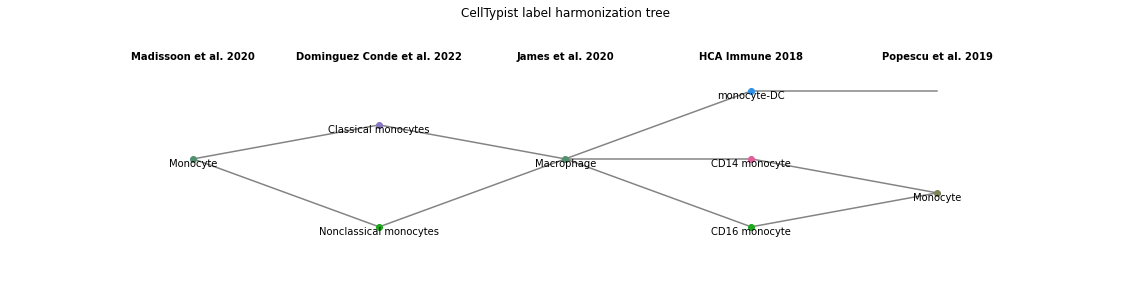

In [23]:
celltypist.treeplot(alignment.relation[alignment.groups=='Group35'], figsize = [20, 5])

In [24]:
celltypist.sankeyplot(alignment.relation[alignment.groups=='Group35'])

Re-harmonise the five datasets with a different order of datasets.

In [25]:
alignment.best_align(['HCA Immune 2018', 'Popescu et al. 2019', 'Madissoon et al. 2020', 'Dominguez Conde et al. 2022', 'James et al. 2020'])

🖇 Harmonizing cell types of HCA Immune 2018 and Popescu et al. 2019
🖇 Harmonizing cell types of Madissoon et al. 2020
🖇 Harmonizing cell types of Dominguez Conde et al. 2022
🖇 Harmonizing cell types of James et al. 2020


Reannotate cells.

In [26]:
alignment.reannotate()

Visualise the results.

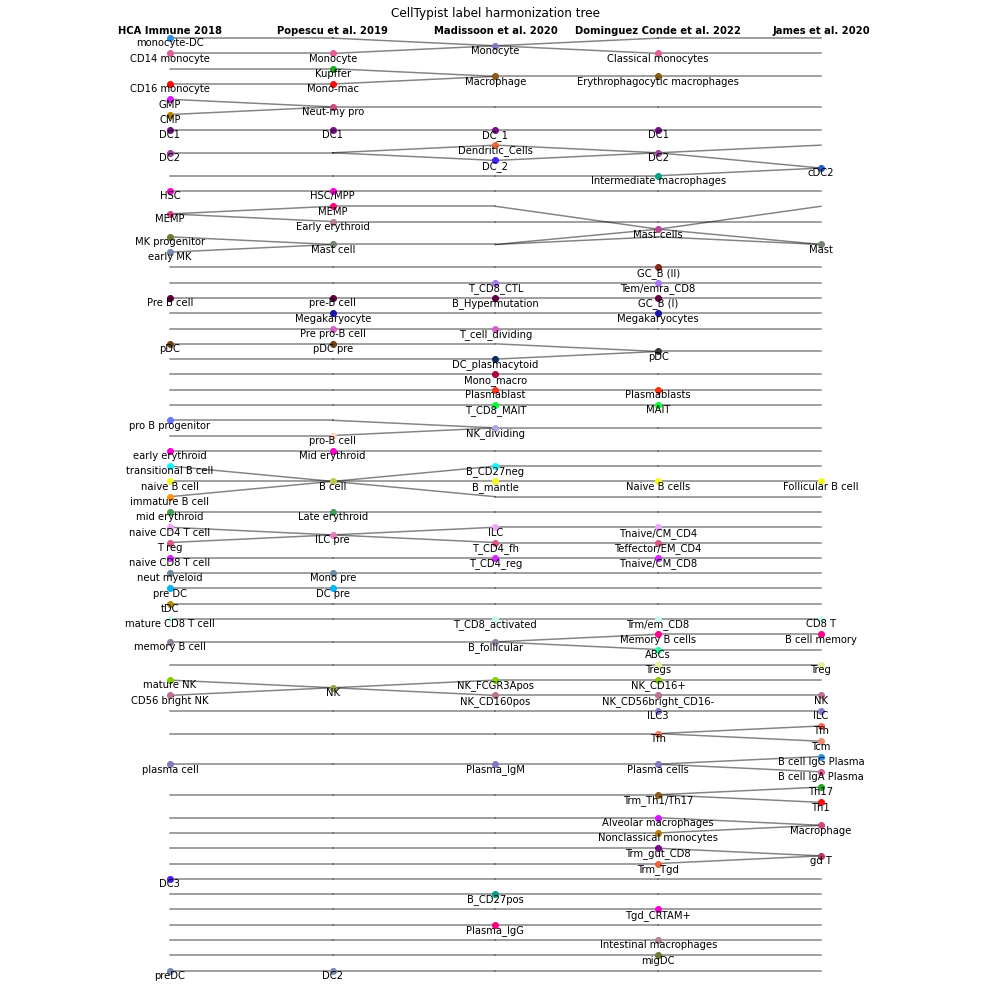

In [27]:
celltypist.treeplot(alignment)

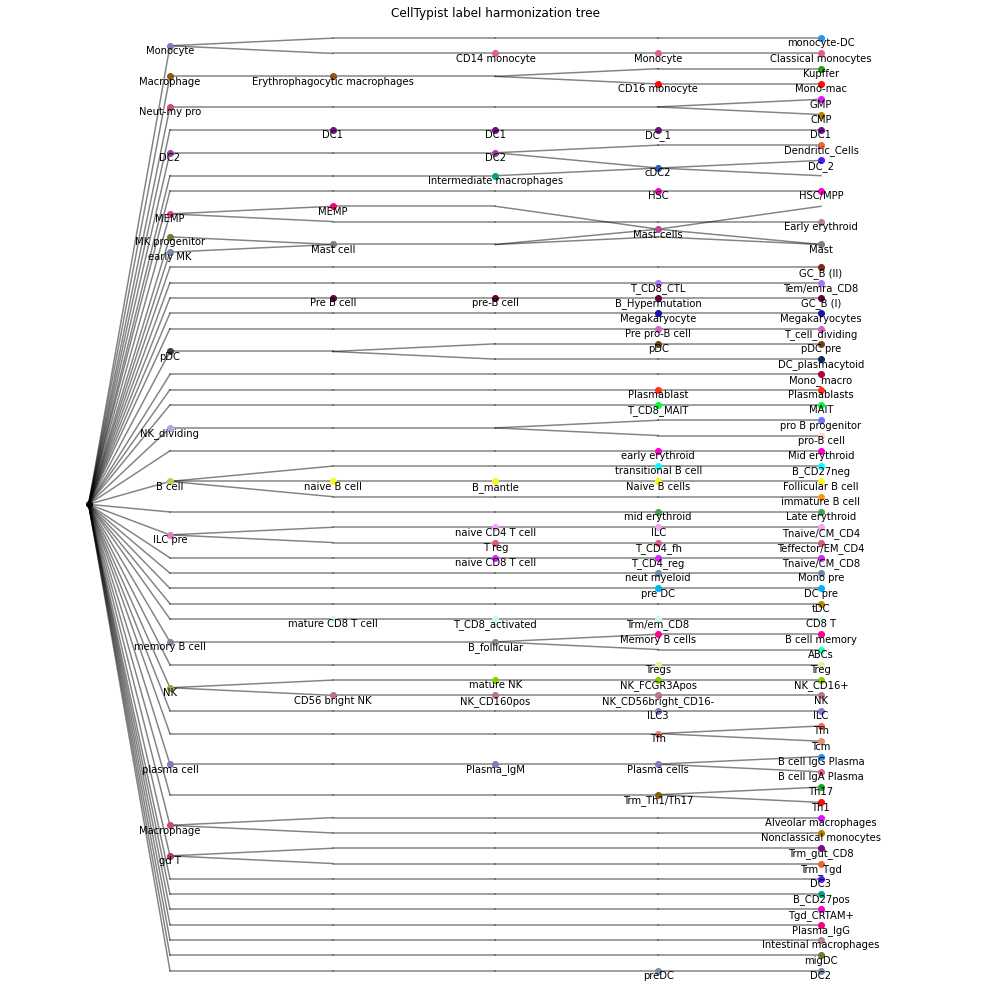

In [28]:
celltypist.treeplot(alignment, order_dataset = True)